In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats
from statannot import add_stat_annotation
from matplotlib import pyplot as plt

from pltconfig import *

In [2]:
# Load endpoint growth data of mutants from four days of growth
# Endpoint data (4 days) from matched 3mL cultures in 10% CO2 and ambient. 
matched_od_4day_df = pd.read_csv('data/mutant_phenotypes/090619_CCMB1_mutants_endpointODs_tubes.csv')
mask = matched_od_4day_df.use == True
matched_od_4day_df = matched_od_4day_df[mask].drop('use', axis=1)

mo4d = matched_od_4day_df
amb_4day_df = mo4d[mo4d.condition == 'ambient']
highCO2_4day_df = mo4d[mo4d.condition == '10% CO2']

# Calculate mean values for the 3mL scale experiment. 
mean_4day_10pct = highCO2_4day_df.groupby('short_name').mean()
mean_amb_4day_df = amb_4day_df.groupby('short_name').mean()

std_4day_10pct = highCO2_4day_df.groupby('short_name').std()
std_4day_amb = amb_4day_df.groupby('short_name').std()

In [3]:
# Endpoint data (12 days) from matched 3mL cultures in 10% CO2 and ambient. 
# Matched cultures in 10% and ambient CO2. 
matched_12day_od_df = pd.read_csv('data/mutant_phenotypes/020420_CCMB1_mutants_endpoint.csv')
mask = matched_12day_od_df.use == True
matched_12day_od_df = matched_12day_od_df[mask].drop('use', axis=1)

mo12d = matched_12day_od_df
highCO2_12day_df = mo12d[mo12d.condition == '10% CO2']
amb_12day_df = mo12d[mo12d.condition == 'ambient']

# Calculate mean values for 12day experiment. 
mean_12day_10pct = highCO2_12day_df.groupby('short_name').mean()
mean_12day_amb = amb_12day_df.groupby('short_name').mean()

std_12day_10pct = highCO2_12day_df.groupby('short_name').std()
std_12day_amb = amb_12day_df.groupby('short_name').std()

mean_12day_amb.head()

,measured_OD,dilution_factor,OD
short_name,,,
DabA1-,0.00000,10,0.0000
cbbL Y72R,0.00000,10,0.0000
cbbQ-,0.47100,10,4.7100
csos2 dNTD,0.00025,10,0.0025
csosCA C173S,0.00000,10,0.0000


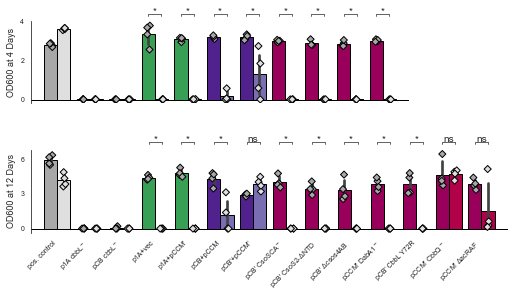

In [4]:
# Combined figure of four day and 12 day growth experiments. 
fig = plt.figure(figsize=(7.25, 4.25))
gs = fig.add_gridspec(2,2, width_ratios=[4.3, 1])
sns.set_style('white')

neg_colors = (greys[3], greys[1])
pos_colors = (greens[-3], greens[-5])
exp_colors = (purples[-1], purples[-3])
mut_colors = (reddish_purple, reddish)
colormap = {'pos': neg_colors,
            'p1A K194M/AGFP': neg_colors,
            'full CCM K194M': neg_colors,
            'p1A/AGFP': pos_colors,
            "p1A/pCCM'": pos_colors,
            'full CCM pre': exp_colors,
            'full CCM post': exp_colors,         
            'csosCA C173S': mut_colors,
            'csos2 dNTD': mut_colors,
            'dcsos4AB': mut_colors,
            'DabA1-': mut_colors,
            'cbbL Y72R': mut_colors,
            'cbbQ-': mut_colors,
            'dacRAF': mut_colors}
hue_order = ['10% CO2', 'ambient']

# 4 day experiment
ax0 = fig.add_subplot(gs[0, 0])
# Set the order for this panel
order = ['pos', 'p1A K194M/AGFP', 'full CCM K194M', 
         'p1A/AGFP', "p1A/pCCM'",
         'full CCM pre', 'full CCM post',
         'csosCA C173S', 'csos2 dNTD', 'dcsos4AB', 'DabA1-', ]
bar_colors = [colormap[o][0] for o in order] + [colormap[o][1] for o in order]
bars = sns.barplot(data=mo4d, x='short_name', y='OD', hue='condition',
                   order=order, hue_order=hue_order, ax=ax0,
                   edgecolor='k', linewidth=1)
for c, bar in zip(bar_colors, bars.patches):
    bar.set_color(c)
    bar.set_edgecolor('k')
    
hue_pal = {'ambient': greys[1], '10% CO2': greys[3]}
sns.stripplot(data=mo4d, x='short_name', y='OD', hue='condition',
              order=order, hue_order=hue_order, ax=ax0,
              marker='D', dodge=0.5, palette=hue_pal, edgecolor='k', linewidth=1)

# One-sided nonparametric test with no multiple testing correction.
# One-sided since ambient should always be worse than high CO2 except for the positive control.
# No correction since each experiment is a self-contained comparison of quadrupliate paired cultures. 
pairs = [((name, '10% CO2'), (name, 'ambient')) for name in order[3:]]
test_results = add_stat_annotation(ax0, data=mo4d, x='short_name', y='OD', order=order,
                                   hue='condition', hue_order=hue_order,
                                   box_pairs=pairs,
                                   test='Mann-Whitney-gt', 
                                   comparisons_correction=None,
                                   text_format='star', text_offset=-2,
                                   line_height=0.02, line_offset=0.08, linewidth=0.75,
                                   loc='outside', verbose=0)

plt.axhline(0, lw=1, c='k')

plt.legend().set_visible(False)
plt.xticks([])
plt.yticks(np.arange(0, 4.1, 2.0), fontsize=7)
plt.xlabel('')
plt.ylabel('OD600 at 4 Days', fontsize=9)
plt.ylim(-0.2, 4.05)
plt.xlim(-0.8, 10.8)
sns.despine(bottom=True)


# 12 day experiment
ax2 = fig.add_subplot(gs[1, :])
# set the order for this panel
order = ['pos', # pos control
         'p1A K194M/AGFP', 'full CCM K194M', # negatives
         'p1A/AGFP', "p1A/pCCM'", # rubisco alone
         'full CCM pre', 'full CCM post', # full CCM +/- evolution
         # mutants with well-understood expected phenotypes 
         'csosCA C173S', 'csos2 dNTD', 'dcsos4AB', 'DabA1-',
         # Rubisco mutant abrogating csos2 binding based on Oltrogge et al.
         'cbbL Y72R',
         # mutants with uncertain expected phenotypes
         'cbbQ-', 'dacRAF', ]
ticknames = ['pos. control', 
             "p1A cbbL$^{-}$", 
             "pCB cbbL$^{-}$", 
             "p1A+vec",
             "p1A+pCCM'",
             "pCB+pCCM",
             "pCB'+pCCM'",
             "pCB' CsoSCA$^-$", 
             "pCB' CsoS2-$\Delta$NTD", 
             "pCB' $\Delta$csos4AB",
             "pCCM' DabA1$^-$",
             "pCB' CbbL Y72R",
             "pCCM' CbbQ$^-$",
             "pCCM' $\Delta$acRAF"]

bar_colors = [colormap[o][0] for o in order] + [colormap[o][1] for o in order]
bars = sns.barplot(data=mo12d, x='short_name', y='OD', hue='condition',
                   order=order, hue_order=hue_order, ax=ax2,
                   edgecolor='k', linewidth=1)
for c, bar in zip(bar_colors, bars.patches):
    bar.set_color(c)
    bar.set_edgecolor('k')

hue_pal = {'ambient': greys[1], '10% CO2': greys[3]}
sns.stripplot(data=mo12d, x='short_name', y='OD', hue='condition',
              order=order, hue_order=hue_order, ax=ax2,
              marker='D', dodge=0.5, palette=hue_pal, edgecolor='k', linewidth=1)

# One-sided nonparametric test with no multiple testing correction as above.
pairs = [((name, '10% CO2'), (name, 'ambient')) for name in order[3:]]
test_results = add_stat_annotation(ax2, data=mo12d, x='short_name', y='OD', order=order,
                                   hue='condition', hue_order=hue_order,
                                   box_pairs=pairs,
                                   test='Mann-Whitney-gt', 
                                   comparisons_correction=None,
                                   text_format='star', text_offset=-2,
                                   line_height=0.02, line_offset=0.08, linewidth=0.75,
                                   loc='outside', verbose=0)

plt.axhline(0, lw=1, c='k')

plt.legend().set_visible(False)
plt.xticks(np.arange(len(ticknames)), ticknames, rotation=45, fontsize=7, ha='right')
plt.yticks(np.arange(0, 6.1, 3.0), fontsize=7)
plt.xlabel('')
plt.ylabel('OD600 at 12 Days', fontsize=9)
plt.ylim(-0.35, 6.8)
plt.xlim(-0.8, 13.8)
sns.despine(bottom=True)

plt.tight_layout(h_pad=3)
plt.savefig('fig4/fig4S1.png')
plt.show()

In [5]:
# Calculate mean effect size for dacRAF
means_12day = mo12d.groupby(['short_name', 'condition']).mean()
tenp_od = means_12day.loc[('dacRAF', '10% CO2')].OD
amb_od = means_12day.loc[('dacRAF', 'ambient')].OD
ratio = tenp_od/amb_od
print('dacRAF mean OD ratio 10%%/ambient: %.1f' % ratio)

means_12day.loc['dacRAF']

dacRAF mean OD ratio 10%/ambient: 2.5


,measured_OD,dilution_factor,OD
condition,,,
10% CO2,0.38400,10,3.8400
ambient,0.15475,10,1.5475


In [6]:
# Calculate median effect size for dacRAF
medians_12day = mo12d.groupby(['short_name', 'condition']).median()
tenp_od = medians_12day.loc[('dacRAF', '10% CO2')].OD
amb_od = medians_12day.loc[('dacRAF', 'ambient')].OD
ratio = tenp_od/amb_od
print('dacRAF median OD ratio 10%%/ambient: %.1f' % ratio)

medians_12day.loc['dacRAF']

dacRAF median OD ratio 10%/ambient: 8.5


,measured_OD,dilution_factor,OD
condition,,,
10% CO2,0.3805,10,3.805
ambient,0.0450,10,0.450
